In [3]:
!pip install -U git+https://github.com/google/jax-cfd.git

import os
import time
import datetime
import pickle
import typing
from typing import Callable, Tuple, List, Union
from functools import partial
from collections import defaultdict
import jax
import jax.numpy as jnp
import numpy as np
import scipy
import scipy.linalg as la

from matplotlib import pyplot as plt
import seaborn as sns 

Array = Union[np.ndarray, jnp.ndarray]

from jax.config import config
config.update("jax_enable_x64", True)

import jax_cfd.base  as cfd
from jax_cfd.data import visualization
from jax_cfd.data import xarray_utils as xru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google/jax-cfd.git to /tmp/pip-req-build-3op_cuh5
  Running command git clone -q https://github.com/google/jax-cfd.git /tmp/pip-req-build-3op_cuh5


In [4]:
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/MSc Dissertation')
os.getcwd()

Mounted at /content/drive


'/content/drive/My Drive/Colab Notebooks/MSc Dissertation'

In [5]:
# SETTING PARAMETERS

Nx = 256
Ny = 256
Lx = 2 * jnp.pi
Ly = 2 * jnp.pi

max_velocity = 5.
density = 1.      # 1.
n_waves = 4 # number of forcing wavelengths

grid = cfd.grids.Grid((Nx, Ny), domain=((0, Lx), (0, Ly)))
kolmogorov = cfd.forcings.kolmogorov_forcing(grid, k=n_waves)

In [19]:
#   JACOBS FUNCTIONS

def jnp_to_gv_tuple(u_jnp: Array, offsets: List[Tuple], 
                    grid: cfd.grids.Grid, bc: cfd.grids.BoundaryConditions) -> Tuple[cfd.grids.GridVariable]:
    gv_list = []
    for i in range(u_jnp.shape[-1]):
        garr = cfd.grids.GridArray(u_jnp[..., i], offsets[i], grid)
        gv_list.append(cfd.grids.GridVariable(garr, bc))
    return tuple(gv_list)

def gv_tuple_to_jnp(gv_tuple: Tuple[cfd.grids.GridVariable]) -> Tuple[Array, List[Tuple]]:
    u_jnp = jnp.stack([gv.data for gv in gv_tuple], axis=-1)
    offsets = [gv.offset for gv in gv_tuple]
    return u_jnp, offsets

def generate_time_forward_map(viscosity: float, T: float) -> Callable[[Tuple[cfd.grids.GridVariable]], Tuple[cfd.grids.GridVariable]]:
    N_steps = jnp.floor(T / dt_stable)
    dt_exact = T / N_steps

    def convect(v): 
        return tuple(cfd.advection.advect_linear(u, v, dt_exact) for u in v)

    time_forward_map = cfd.funcutils.repeated(
        cfd.equations.semi_implicit_navier_stokes(
            density=density, viscosity=viscosity, dt=dt_exact, grid=grid, forcing=kolmogorov, convect=convect),
        steps=N_steps)
    return jax.jit(time_forward_map)

def apply_forward_map_T(u_initial: Tuple[cfd.grids.GridVariable], 
                        T: float, t_substep=.1) -> Tuple[cfd.grids.GridVariable]:
    """ Advance solution forward T by repeated application a forward map over t_substep """ 
    N_substeps = jnp.floor(T / t_substep)
    t_remains = T - (N_substeps - 1) * t_substep # make sure we always have > one substep remaining

    map_substep = generate_time_forward_map(viscosity, t_substep)
    map_bulk = jax.jit(cfd.funcutils.repeated(jax.remat(map_substep), steps=N_substeps-1))
    u_bulk = map_bulk(u_initial)
    map_remain = generate_time_forward_map(viscosity, t_remains)
    u_final = map_remain(u_bulk)
    return u_final  

def generate_trajectory_fn(viscosity: float, T: float):
  """ Note approximate T here, this is for RFA. dt_snap = 1 [needs updating] """ 
  dt_stable = cfd.equations.stable_time_step(max_velocity, 0.5, viscosity, grid) / 2. # should take care here
  N_steps_total = jnp.floor(T / dt_stable) #T // dt_stable
  dt_exact = T / N_steps_total

  N_steps_per_substep = jnp.floor(1. / dt_exact)
  N_substeps = N_steps_total // N_steps_per_substep

  def convect(v): 
    return tuple(cfd.advection.advect_linear(u, v, dt_exact) for u in v)

  step_fn = cfd.funcutils.repeated(
      cfd.equations.semi_implicit_navier_stokes(
          density=density, viscosity=viscosity, dt=dt_exact, grid=grid, forcing=kolmogorov, convect=convect),
          steps=N_steps_per_substep)
  
  trajectory_fn = jax.jit(cfd.funcutils.trajectory(jax.remat(step_fn), N_substeps)) 
  return trajectory_fn

def vorticity(ds):
  return (ds.v.differentiate('x') - ds.u.differentiate('y')).rename('vorticity')





# MY FUNCTIONS

def get_traj(Re,T) :

  seed = np.random.randint(1,10000)
  v0 = cfd.initial_conditions.filtered_velocity_field(jax.random.PRNGKey(seed), grid, 5.)
  rollout_fn = jax.jit(generate_trajectory_fn(1/Re, T))
  time,traj = jax.device_get(rollout_fn(v0))
  u = np.transpose(traj[0].data,axes=(0,2,1))
  v = np.transpose(traj[1].data,axes=(0,2,1))

  return u,v

def n_snapshots(Re,T,n,burnin=100) :
  '''
  Finds n snapshots of the velocity field which will be randomly distributed
  within interval (burnin,T) for a given Reynolds number, Re.
  n<=T-burnin and T>burnin required.
  Returns the two arrays of shape (n,Nx,Ny) of velocity fields at the chosen indices.
  '''
  u,v = get_traj(Re,T)
  u,v = u[burnin:],v[burnin:]
  snap_indices = np.random.choice(T-burnin, n, replace=False)
  u,v = u[snap_indices],v[snap_indices]

  return u,v

def snap_dict(Re_range,T,n,burnin,n_Re) :    # Note this will overwrite velocity arrays of the same Re value, i.e. only one lot of n 
                                             # stored in in the dictionary for each Re. Will need to change if integer Reynolds are chosen.
  '''                                        
  Creates dictionary of Reynolds numbers as keys and n snapshots of u and v velocity arrays in shape (n,Nx,Ny,2) as values
Re_range - list/tuple of lower and upper limit of interval to choose Re over.
T - timesteps taken for each Re
n - number of snapshots to take per simulation (post-burnin)
burnin - number of timesteps to dicard 
n_Re - The number of different simulations to run (each at random Reynolds number in Re_range)
  '''
  dic = {}

  Re_list = np.random.uniform(Re_range[0],Re_range[1],n_Re)

  for Re in Re_list :
    u,v = n_snapshots(Re,T,n,burnin)
    u = np.expand_dims(u, 3)
    v = np.expand_dims(v, 3)
    dic[Re] = np.concatenate((u,v),3)
    
  return dic

def Low_pass_filter(snapshot,cut_off) :
  '''
Takes in a velocity snapshot in the form of a 3D array (Ny,Nx,2), computes the 2D FFT of the array.
Terms with wavenumber that exceed cut_off value will removed and the inverse FFT will be applied to 
return a a new filtered velocity snapshot.
  '''
  (Nx,Ny,_) = snapshot.shape
  FT = np.fft.fft2(snapshot,axes=(0,1))   # Take FT of axes (2,1) to change coordinate indexing into row column indexing.
  kx = 2*np.pi*np.fft.fftfreq(Nx,(2*np.pi)/Nx)
  ky = 2*np.pi*np.fft.fftfreq(Ny,(2*np.pi)/Ny)
  kx2 = kx**2
  ky2 = ky**2
  K_grid = np.sqrt( np.tile(kx2,(Ny,1)) + np.tile(np.array([ky2]).T,(1,Nx)) )
  filtered = np.zeros((Ny,Nx,2),dtype=complex)

  for i in range(Nx) :      # Could make this a lot more efficient by (1) only doing for loop over square of points around zero after reordering (with side length 2*cut_off) (2) using symmetry properties.
    
    for j in range(Ny) :

      if K_grid[i,j] <= cut_off :
        filtered[i,j] = FT[i,j]

  return np.real(np.fft.ifft2(filtered,axes=(0,1)))

def LPS(data,cut_off) :

    n_snaps = data.shape[0]

    for i in range(n_snaps) :
        data[i] = Low_pass_filter(data[i],cut_off)

    return data

def dict_to_input(d) :
  '''
  Transforming data in dictionary into a form permissible as input to CNN.
  Outputs the design matrix and corresponding labels.
  '''
  vals = list(d.values())
  n = vals[0].shape[0]  # Number of snapshots per Re

  # Keys to 1D labels array
  Re = np.asarray(list(d.keys()))
  Re = np.expand_dims(Re,1)
  labels = np.tile(Re,n)
  labels = labels.flatten()

  # Values to (n*n_Re,Nx,Ny,2) sized array
  X = np.concatenate(vals)
  
  return X, labels

def xy_shift(snaps,x_shift,y_shift) :
  """ 
  Shift field along a continuous symmetry 
  Assumes data is periodic, uniform grid etc
  Takes an array as input with shape (n,Nx,Nx,2).
  x_shift and y_shift can either both be floats
  or both be lists/(one-dimensional arrays) of 
  length n.
  +ve x_shift is to the right
  +ve y_shift is down
  """
  Nx,Ny = snaps.shape[1:3]
  x_shift = np.array(x_shift)
  y_shift = np.array(y_shift)

  FT = np.fft.fft2(snaps,axes=(1,2))

  kx = 2*np.pi*np.fft.fftfreq(Nx,(2*np.pi)/Nx)
  ky = 2*np.pi*np.fft.fftfreq(Ny,(2*np.pi)/Ny)
  Kx,Ky = np.meshgrid(kx,ky)

  if type(x_shift) == (float or int) :
    shift_factor = np.exp(-1j*(Kx*x_shift+Ky*y_shift))
    shift_factor = np.expand_dims(shift_factor, (0,3))

  else :    # Then assume 1d array of len n
    x_shift, y_shift = x_shift[:,np.newaxis,np.newaxis], y_shift[:,np.newaxis,np.newaxis]
    Kx, Ky = Kx[np.newaxis,:], Ky[np.newaxis,:]
    shift_factor = np.exp(-1j*(Kx*x_shift+Ky*y_shift))
    shift_factor = shift_factor[:,:,:,np.newaxis]

  FT_shifted = shift_factor*FT
  shifted = np.real(np.fft.ifft2(FT_shifted,axes=(1,2)))

  return shifted

def snap_dict2(Re_range,T,n,burnin) :    # Note this will overwrite velocity arrays of the same Re value, i.e. only one lot of n 
                                             # stored in in the dictionary for each Re. Will need to change if integer Reynolds are chosen.
  '''                                        
  Creates dictionary of Reynolds numbers as keys and n snapshots of u and v velocity arrays in shape (n,Nx,Ny,2) as values
Re_range - list/tuple of lower and upper limit of interval to choose Re over.
T - timesteps taken for each Re
n - number of snapshots to take per simulation (post-burnin)
burnin - number of timesteps to dicard 
  '''
  dic = {}

  Re_list = np.array(range(Re_range[0],Re_range[1]))

  for Re in Re_list :
    u,v = n_snapshots(Re,T,n,burnin)
    u = np.expand_dims(u, 3)
    v = np.expand_dims(v, 3)
    dic[Re] = np.concatenate((u,v),3)
    
  return dic

def Vis_before_and_after(snapshot,cut_off) :
  '''
  Takes a (Ny,Nx,2) shaped velocity snapshot array and returns a visualisation 
  of the vorticity before and after the application of a low-pass filter.
  The low-pass filter cuts off wavenumbers where |k| > cut_off.
  '''
  (Nx,Ny,_) = snapshot.shape

  # Initial vorticity visualisation :
  fig, axs = plt.subplots(1,2,figsize=(20,8))
  plt.suptitle(f'Low-pass filter with cut-off |k| > {cut_off}',fontsize=23)

  snapshot_T = snapshot.T
  xarray = xru.velocity_trajectory_to_xarray(
  tuple([snapshot_T[0:1,:,:],snapshot_T[1:2,:,:]]),
  grid)
  vort = xarray.pipe(vorticity).data.T

  axs[0].imshow(vort[:,:,0], cmap=sns.cm.icefire,vmin=-6, vmax=6)
  axs[0].set_title('Before filterisation',fontsize=17)
  
  # Put snapshot through Low-pass filter :
  after = Low_pass_filter(snapshot,cut_off)
  after_T = after.T

  # Visualise filtered vorticity :
  xarray = xru.velocity_trajectory_to_xarray(
  tuple([after_T[0:1,:,:],after_T[1:2,:,:]]),
  grid)
  vort = xarray.pipe(vorticity).data.T

  im = axs[1].imshow(vort[:,:,0], cmap=sns.cm.icefire,vmin=-6, vmax=6)
  axs[1].set_title('After filterisation',fontsize=17)

  # Get colourbar
  fig.subplots_adjust(right=0.8)
  cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
  fig.colorbar(im, cax=cbar_ax)

  return fig,axs

In [9]:
# GENERATE DATA

start = time.time()

# Training

Re_range = (30,80) # Re_range - list/tuple of lower and upper limit of interval to choose Re over.
T = 51             # T - timesteps taken for each Re
n = 50           # n - number of snapshots to take per simulation (post-burnin)
burnin = 1        # burnin - number of timesteps to dicard 
n_Re = 1           # n_Re - The number of different simulations to run (each at random Reynolds number in Re_range)

d = snap_dict(Re_range,T,n,burnin,n_Re)
x_train,y_train = dict_to_input(d)
train_snaps = T*n_Re
train_snaps_burn = n*n_Re
print('\nTRAINING\n\nSnapshots generated = ',train_snaps,'\n\nSnapshots to be used = ',train_snaps_burn)

# Testing
Re_range = (64,81) # Re_range - list/tuple of lower and upper limit of interval to choose Re over.                        # (30,80)
T = 1             # T - timesteps taken for each Re                                                                     # 200
n = 1           # n - number of snapshots to take per simulation (post-burnin)                                          # 100
burnin = 0      # burnin - number of timesteps to dicard                                                              # 100
n_Re = 1           # n_Re - The number of different simulations to run (each at random Reynolds number in Re_range)      # 10

d_test = snap_dict2(Re_range,T,n,burnin)
x_test,y_test = dict_to_input(d_test)

test_snaps = T*n_Re
test_snaps_burn = n*n_Re
# number_of_snaps = train_snaps + test_snaps
# number_of_snaps_after_burn = train_snaps_burn + test_snaps_burn
# end = time.time()
# elapsed = end - start

print('\n\nTESTING\n\nSnapshots generated = ',str(n_Re*T),'\n\nSnapshots to be used = ',str(test_snaps_burn))
# print(f'\n\nTime taken to produce {number_of_snaps} snapshots ({number_of_snaps_after_burn} to be exported): {elapsed/3600} hrs \nSnapshots per hour : {(3600*number_of_snaps)/elapsed}')


TRAINING

Snapshots generated =  51 

Snapshots to be used =  50


TESTING

Snapshots generated =  1 

Snapshots to be used =  1


In [10]:
# Shift data continuously at random in x and discretely in the random multiples of the wavelength of the forcing (pi/2).

train_x_shifts = np.random.uniform(0,2*np.pi,train_snaps_burn)
train_y_shifts = np.random.randint(0,4,train_snaps_burn)*(np.pi/2)
test_x_shifts = np.random.uniform(0,2*np.pi,test_snaps_burn)
test_y_shifts = np.random.randint(0,4,test_snaps_burn)*(np.pi/2)

x_train = xy_shift(x_train,train_x_shifts,train_y_shifts)
x_test = xy_shift(x_test,test_x_shifts,test_y_shifts)

In [11]:
# Save (x_train, y_train, x_test, y_test, Nx, Ny) as a pickled tuple

file = open('Data/test_data_64_80.pickle','wb')
pickle.dump((x_test,y_test), file)
file.close()

In [12]:
x_test.shape

(17, 256, 256, 2)

In [13]:
filtered = LPS(x_test,3)

In [14]:
filtered.shape

(17, 256, 256, 2)

(<Figure size 1440x576 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb47911d090>,
       dtype=object))

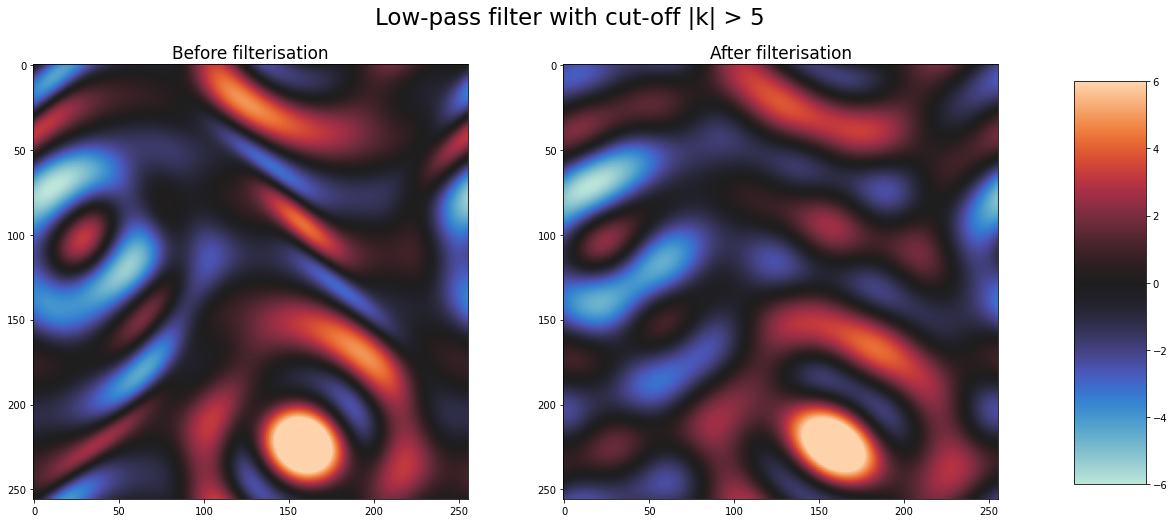

In [22]:
Vis_before_and_after(x_train[40],5)